In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize

pd.set_option('display.max_columns', 1800)
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
mpl.rc('savefig', dpi=200)
params = {'figure.dpi' : 200,
          'figure.figsize' : (12, 10),
          'axes.axisbelow' : True,
          'lines.antialiased' : True,
          'axes.titlesize' : 'xx-large',
          'axes.labelsize' : 'x-large',
          'xtick.labelsize' : 'large',
          'ytick.labelsize' : 'large'}

for (k, v) in params.items():
    plt.rcParams[k] = v

In [3]:
data = pd.DataFrame()
files = ['data/MERGED2003_PP.csv', 'data/MERGED2005_PP.csv',
         'data/MERGED2007_PP.csv']
dfs = []
for file in files:
    df = pd.read_csv(file, low_memory=False)
    print(df.shape)
    df['type'] = 'training'
    dfs.append(df)

data = pd.concat(dfs)

(6585, 1729)
(6824, 1729)
(6890, 1729)


In [4]:
testing = pd.read_csv('data/MERGED2011_PP.csv', low_memory=False)
print(testing.shape)
testing['type'] = 'testing'

(7675, 1729)


In [5]:
data = pd.concat([data, testing])

In [6]:
cols_target = ['md_earn_wne_p6']

cols_school = ['PREDDEG', 'HIGHDEG', 'CONTROL', 'NUMBRANCH', 'AVGFACSAL']
#                'PCIP01', 'PCIP03', 'PCIP04', 'PCIP05', 'PCIP09', 'PCIP10',
#                'PCIP11', 'PCIP12', 'PCIP13', 'PCIP14', 'PCIP15', 'PCIP16',
#                'PCIP19', 'PCIP22', 'PCIP23', 'PCIP24', 'PCIP25', 'PCIP26',
#                'PCIP27', 'PCIP29', 'PCIP30', 'PCIP31', 'PCIP38', 'PCIP39',
#                'PCIP40', 'PCIP41', 'PCIP42', 'PCIP43', 'PCIP44', 'PCIP45',
#                'PCIP46', 'PCIP47', 'PCIP48', 'PCIP49', 'PCIP50', 'PCIP51',
#                'PCIP52', 'PCIP54']

# cols_admissions = ['ADM_RATE', 'SATVR25', 'SATVR75', 'SATMT25', 'SATMT75', 'SAT_AVG']

cols_costs = ['TUITFTE']

cols_studentbody = ['UGDS', 'UGDS_NRA', 'PPTUG_EF', 'UG25abv',
                    'PAR_ED_PCT_1STGEN', 'DEP_INC_AVG', 'IND_INC_AVG',
                    'COMP_ORIG_YR2_RT', 'WDRAW_ORIG_YR2_RT', 'ENRL_ORIG_YR2_RT',
                    'COMP_ORIG_YR4_RT', 'WDRAW_ORIG_YR4_RT', 'ENRL_ORIG_YR4_RT',
                    'OVERALL_YR2_N', 'OVERALL_YR3_N', 'OVERALL_YR4_N',
                    'OVERALL_YR6_N', 'OVERALL_YR8_N', 'count_nwne_p6']

cols_financialaid = ['DEBT_MDN', 'GRAD_DEBT_MDN', 'WDRAW_DEBT_MDN']

cols_other = ['type']

In [7]:
data.shape

(27974, 1730)

In [8]:
data_reduced = data[cols_target+cols_school+cols_costs+\
                    cols_studentbody+cols_financialaid+cols_other]

In [9]:
for c in data_reduced.columns:
    if (data_reduced[c].dtype == object) and (c != 'type'):
        data_reduced[c] = data_reduced[c].apply(lambda x: float(x) if x != 'PrivacySuppressed' else np.nan)
        data_reduced[c] = data_reduced[c].astype(float)

In [10]:
data_reduced.describe()

,md_earn_wne_p6,PREDDEG,HIGHDEG,CONTROL,NUMBRANCH,AVGFACSAL,TUITFTE,UGDS,UGDS_NRA,PPTUG_EF,UG25abv,PAR_ED_PCT_1STGEN,DEP_INC_AVG,IND_INC_AVG,COMP_ORIG_YR2_RT,WDRAW_ORIG_YR2_RT,ENRL_ORIG_YR2_RT,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,ENRL_ORIG_YR4_RT,OVERALL_YR2_N,OVERALL_YR3_N,OVERALL_YR4_N,OVERALL_YR6_N,OVERALL_YR8_N,count_nwne_p6,DEBT_MDN,GRAD_DEBT_MDN,WDRAW_DEBT_MDN
count,22394.000000,27974.000000,27974.000000,27974.000000,27974.000000,17094.000000,26958.000000,26084.000000,26084.000000,25961.000000,25830.000000,24461.000000,25166.000000,25303.000000,22303.000000,22473.000000,20116.000000,22184.000000,21849.000000,19316.000000,26230.000000,25815.000000,25535.000000,24948.000000,18614.000000,24423.000000,22847.000000,21627.000000,21315.000000
mean,29062.007681,1.857582,2.213877,2.118932,4.037070,5348.674798,11011.289970,2222.314944,0.014165,0.223849,0.413015,0.493549,52556.296987,22942.376603,0.278013,0.205554,0.238424,0.374718,0.205404,0.040188,2614.042242,2266.867209,1965.423497,1385.139370,1334.820297,249.651435,8994.602180,12483.039742,6405.177668
std,10822.399280,1.008607,1.274660,0.841436,12.977136,1935.658093,172001.637782,4855.392337,0.043849,0.240339,0.220127,0.135478,24402.757134,9926.116828,0.254066,0.135533,0.195519,0.243561,0.144668,0.050813,14366.819640,13225.712340,10592.497586,5225.296605,5179.278829,891.605076,4821.270423,7030.661573,3447.324241
min,7000.000000,0.000000,0.000000,1.000000,1.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000400,0.000000,443.174960,215.042694,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.000000,124.000000,654.000000,520.000000
25%,22000.000000,1.000000,1.000000,1.000000,1.000000,4088.250000,2537.750000,127.000000,0.000000,0.000000,0.253025,0.413534,33732.107442,16257.267275,0.062918,0.106195,0.060261,0.155203,0.101010,0.000000,119.000000,116.000000,114.000000,107.000000,111.000000,23.000000,5400.000000,6625.000000,3750.000000
50%,27500.000000,2.000000,2.000000,2.000000,1.000000,5160.000000,5909.000000,522.000000,0.000000,0.145700,0.411000,0.510294,49126.867425,21397.270020,0.160684,0.198300,0.204279,0.378328,0.195652,0.025147,450.000000,420.000000,407.000000,373.000000,369.000000,66.000000,7905.000000,11119.000000,5500.000000
75%,34400.000000,3.000000,4.000000,3.000000,2.000000,6376.000000,10877.750000,2067.000000,0.011200,0.386400,0.563400,0.581560,68785.735878,27541.043335,0.514689,0.293532,0.391884,0.571936,0.295954,0.066380,1350.000000,1230.000000,1139.500000,994.000000,968.000000,186.000000,12000.000000,17125.000000,8250.000000
max,133600.000000,4.000000,4.000000,3.000000,128.000000,24699.000000,26670163.000000,249604.000000,1.000000,1.000000,1.000000,1.000000,181008.007100,79375.209910,1.000000,0.781513,1.000000,1.000000,0.842161,0.694737,237888.000000,222715.000000,170316.000000,72057.000000,70824.000000,12567.000000,95984.000000,47186.500000,33125.000000


In [11]:
data_reduced.dropna(inplace=True)

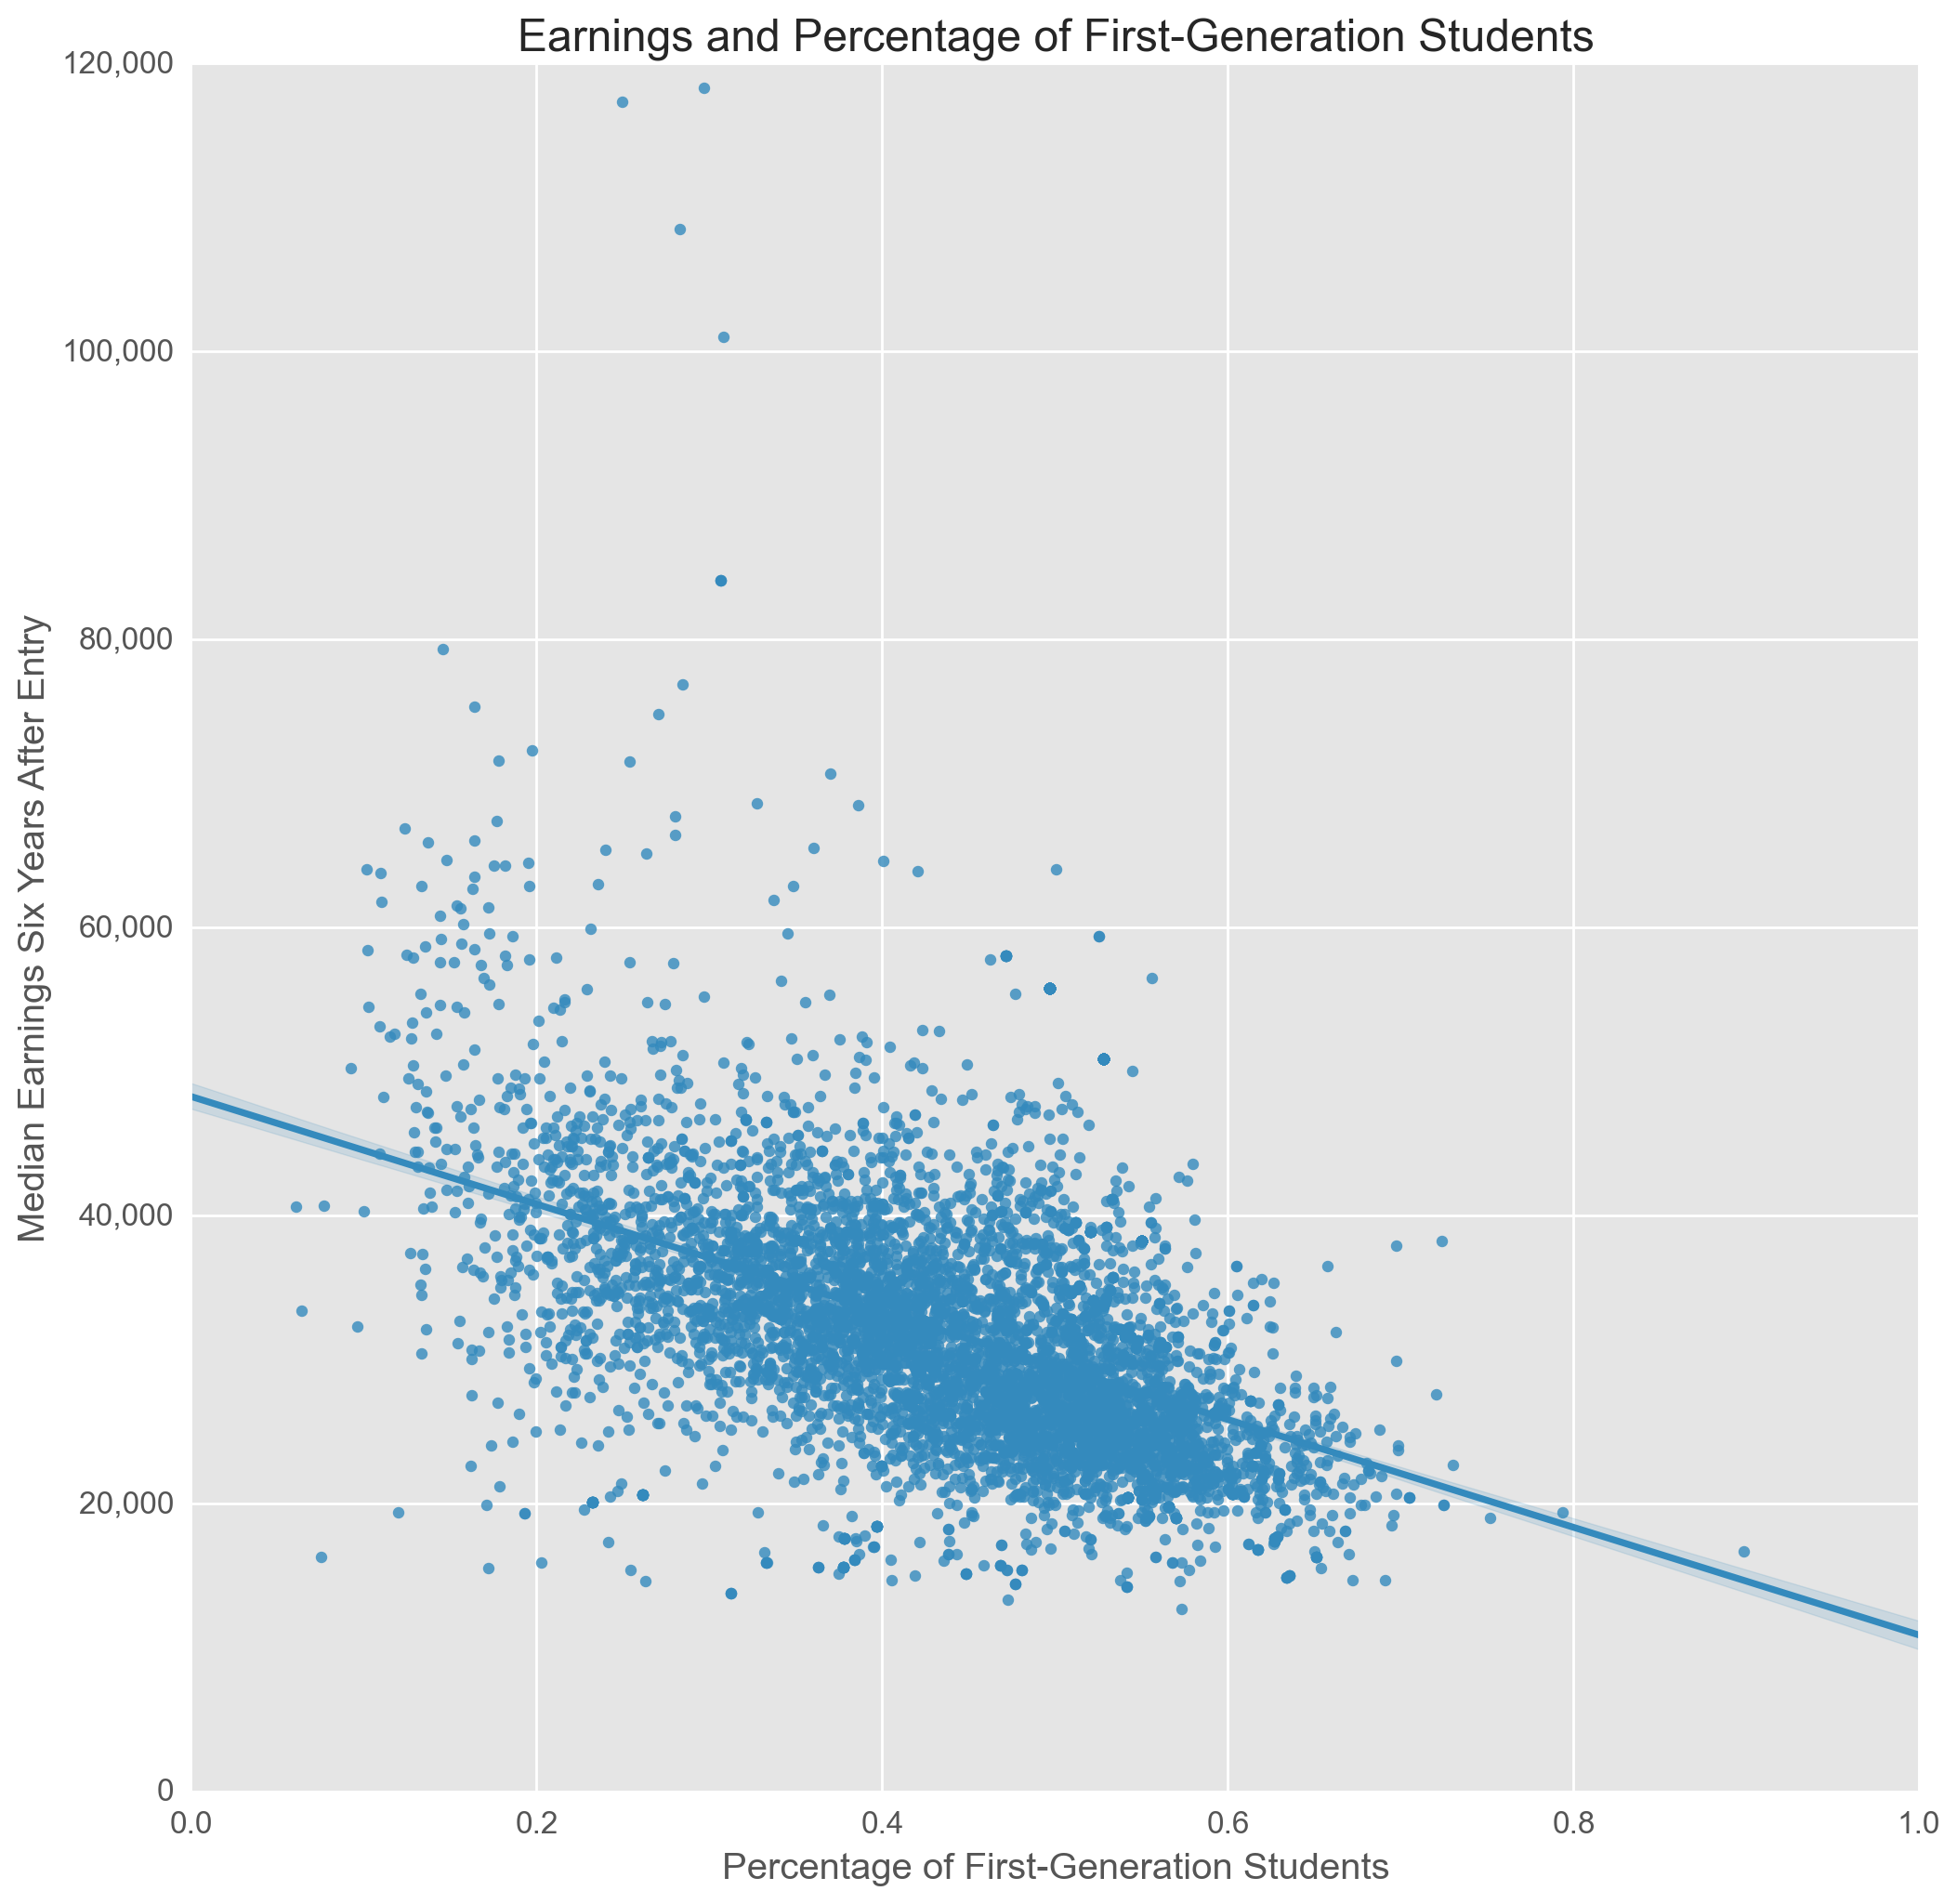

In [12]:
plt.figure(figsize=(12, 12))

sns.regplot(x=data_reduced.PAR_ED_PCT_1STGEN, y=data_reduced.md_earn_wne_p6, color='#348ABD');

plt.title('Earnings and Percentage of First-Generation Students')
plt.xlabel('Percentage of First-Generation Students')
plt.ylabel('Median Earnings Six Years After Entry')

plt.ylim(0, 120000);

plt.gca().get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda y, p: format(int(y), ','))
)

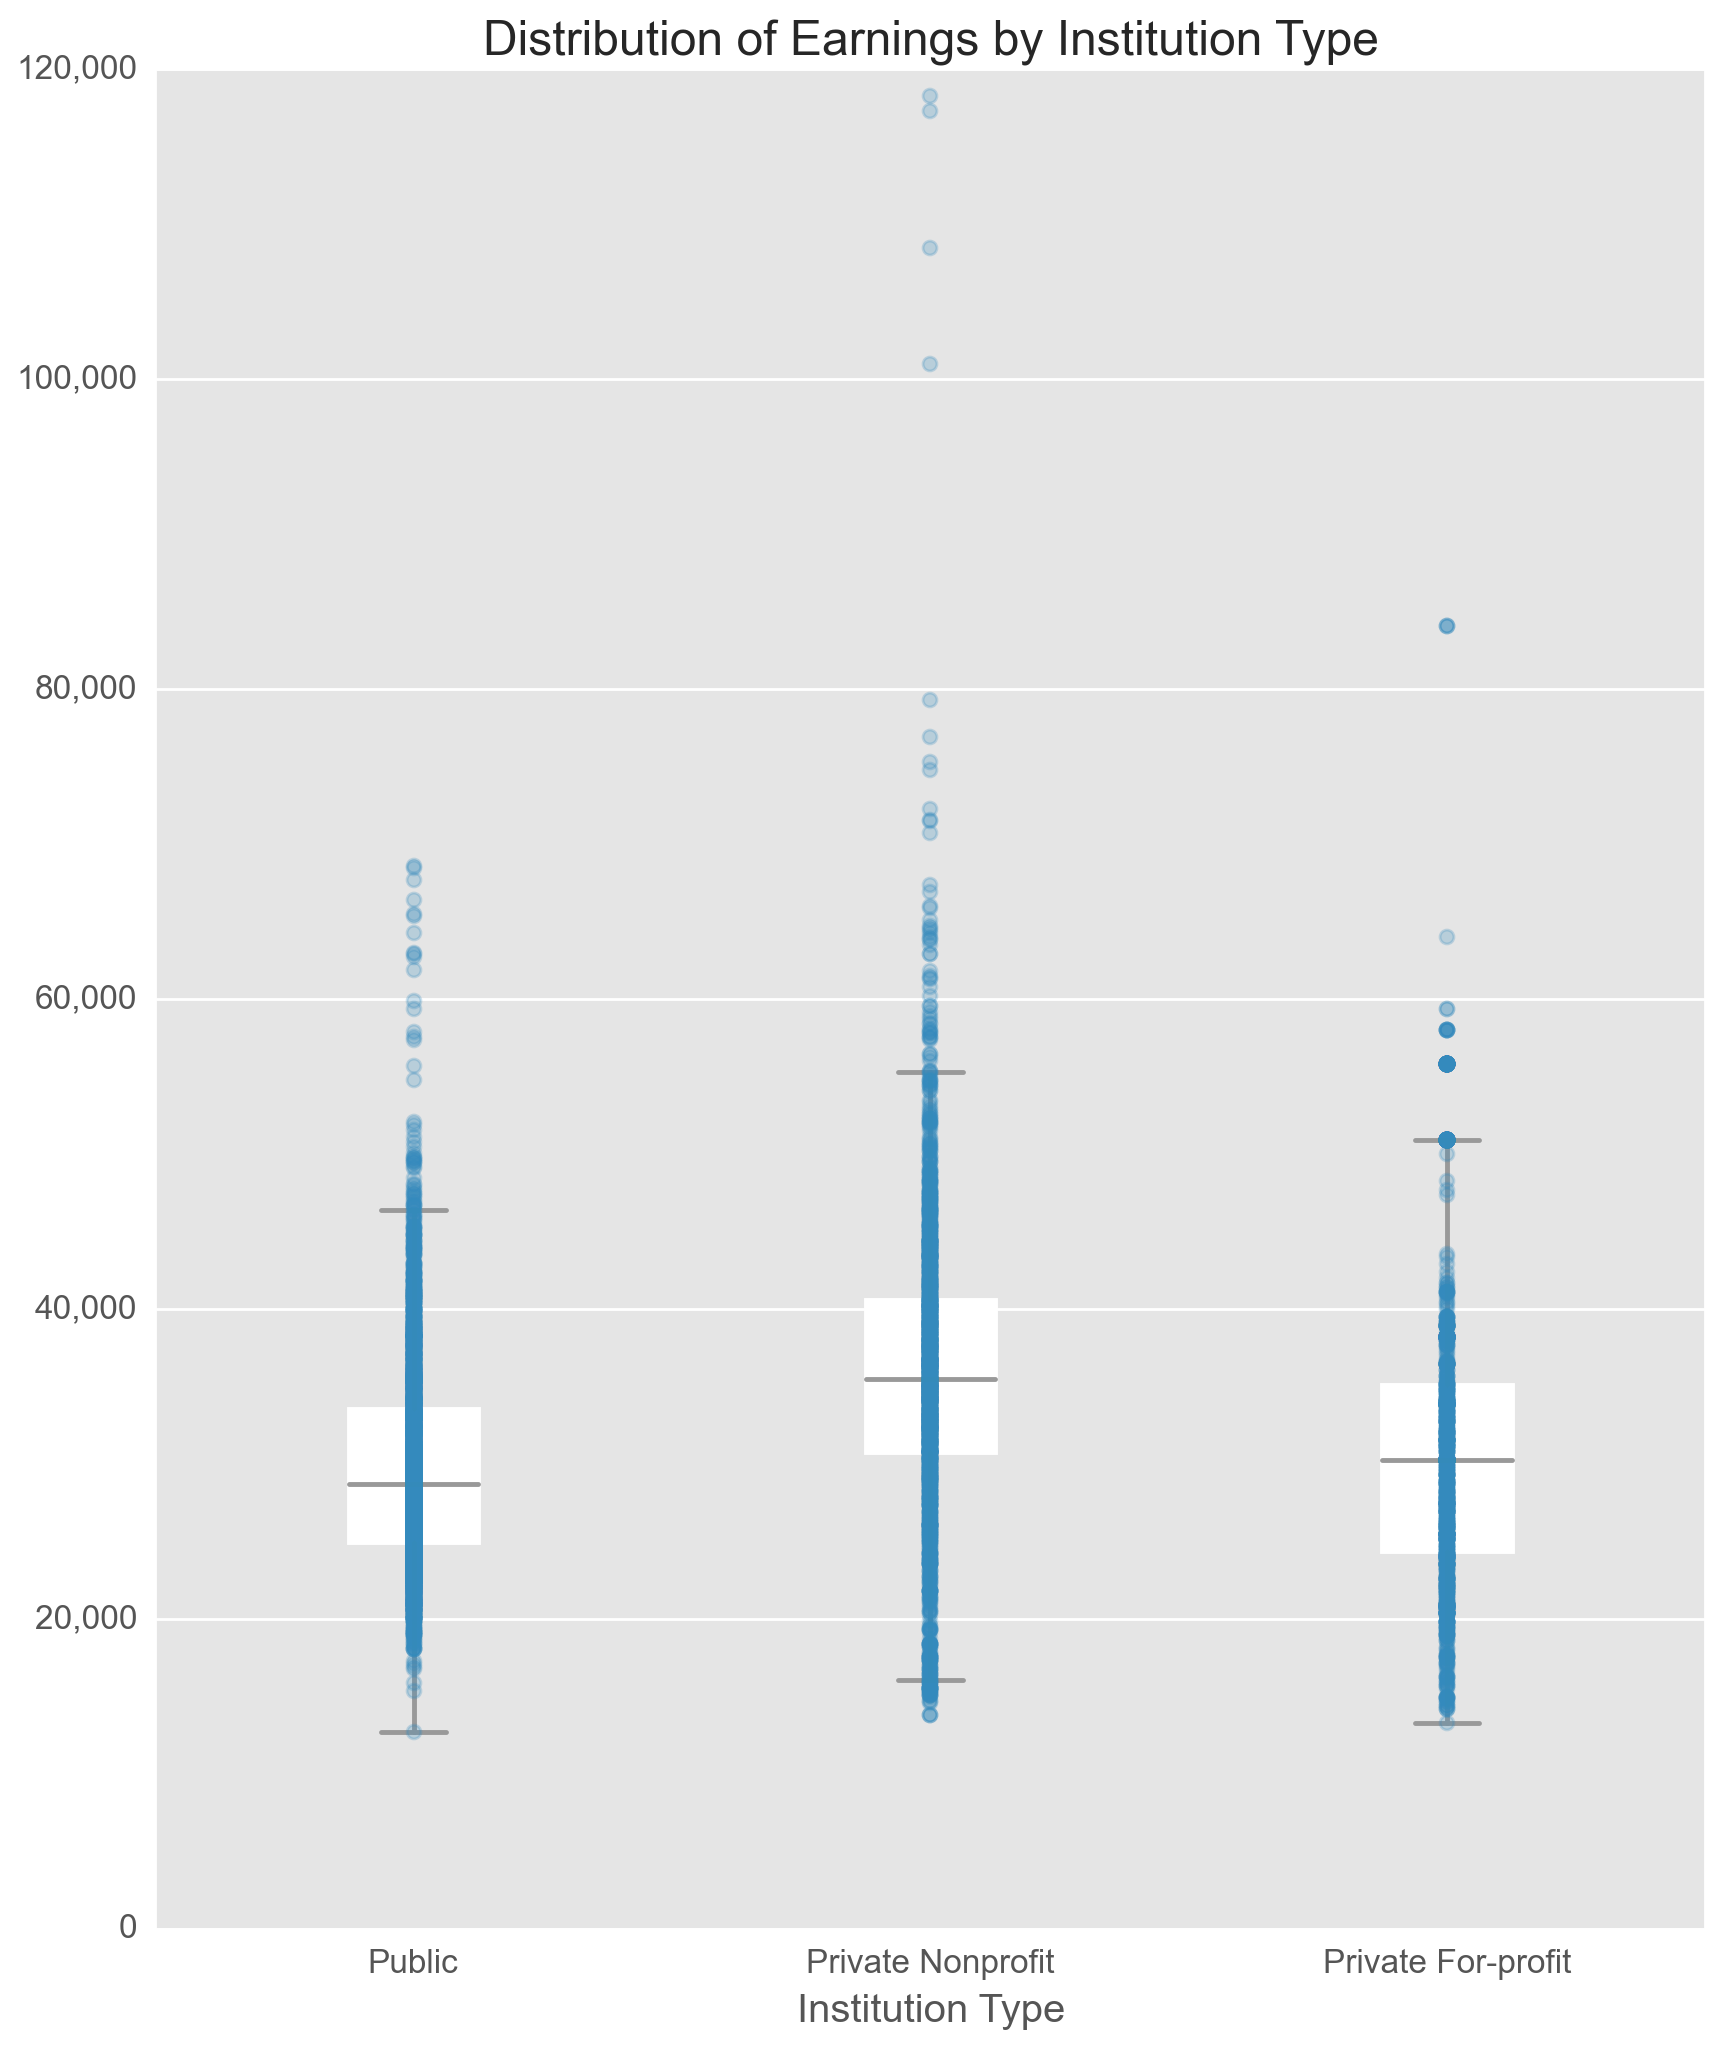

In [13]:
plt.figure(figsize=(10, 12))

sns.boxplot(x="CONTROL", y="md_earn_wne_p6", data=data_reduced,
            order=np.sort(data_reduced.CONTROL.unique()), color='White',
            fliersize=0, width=0.25)
sns.stripplot(x="CONTROL", y="md_earn_wne_p6", data=data_reduced,
              order=np.sort(data_reduced.CONTROL.unique()),
              alpha=0.25, size=5,
              color='#348ABD', edgecolor='#348ABD')

plt.title('Distribution of Earnings by Institution Type')
plt.xlabel('Institution Type')
plt.ylabel('')

plt.xticks(range(3), ['Public', 'Private Nonprofit', 'Private For-profit'])

plt.ylim(0, 120000);

plt.gca().get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda y, p: format(int(y), ','))
)

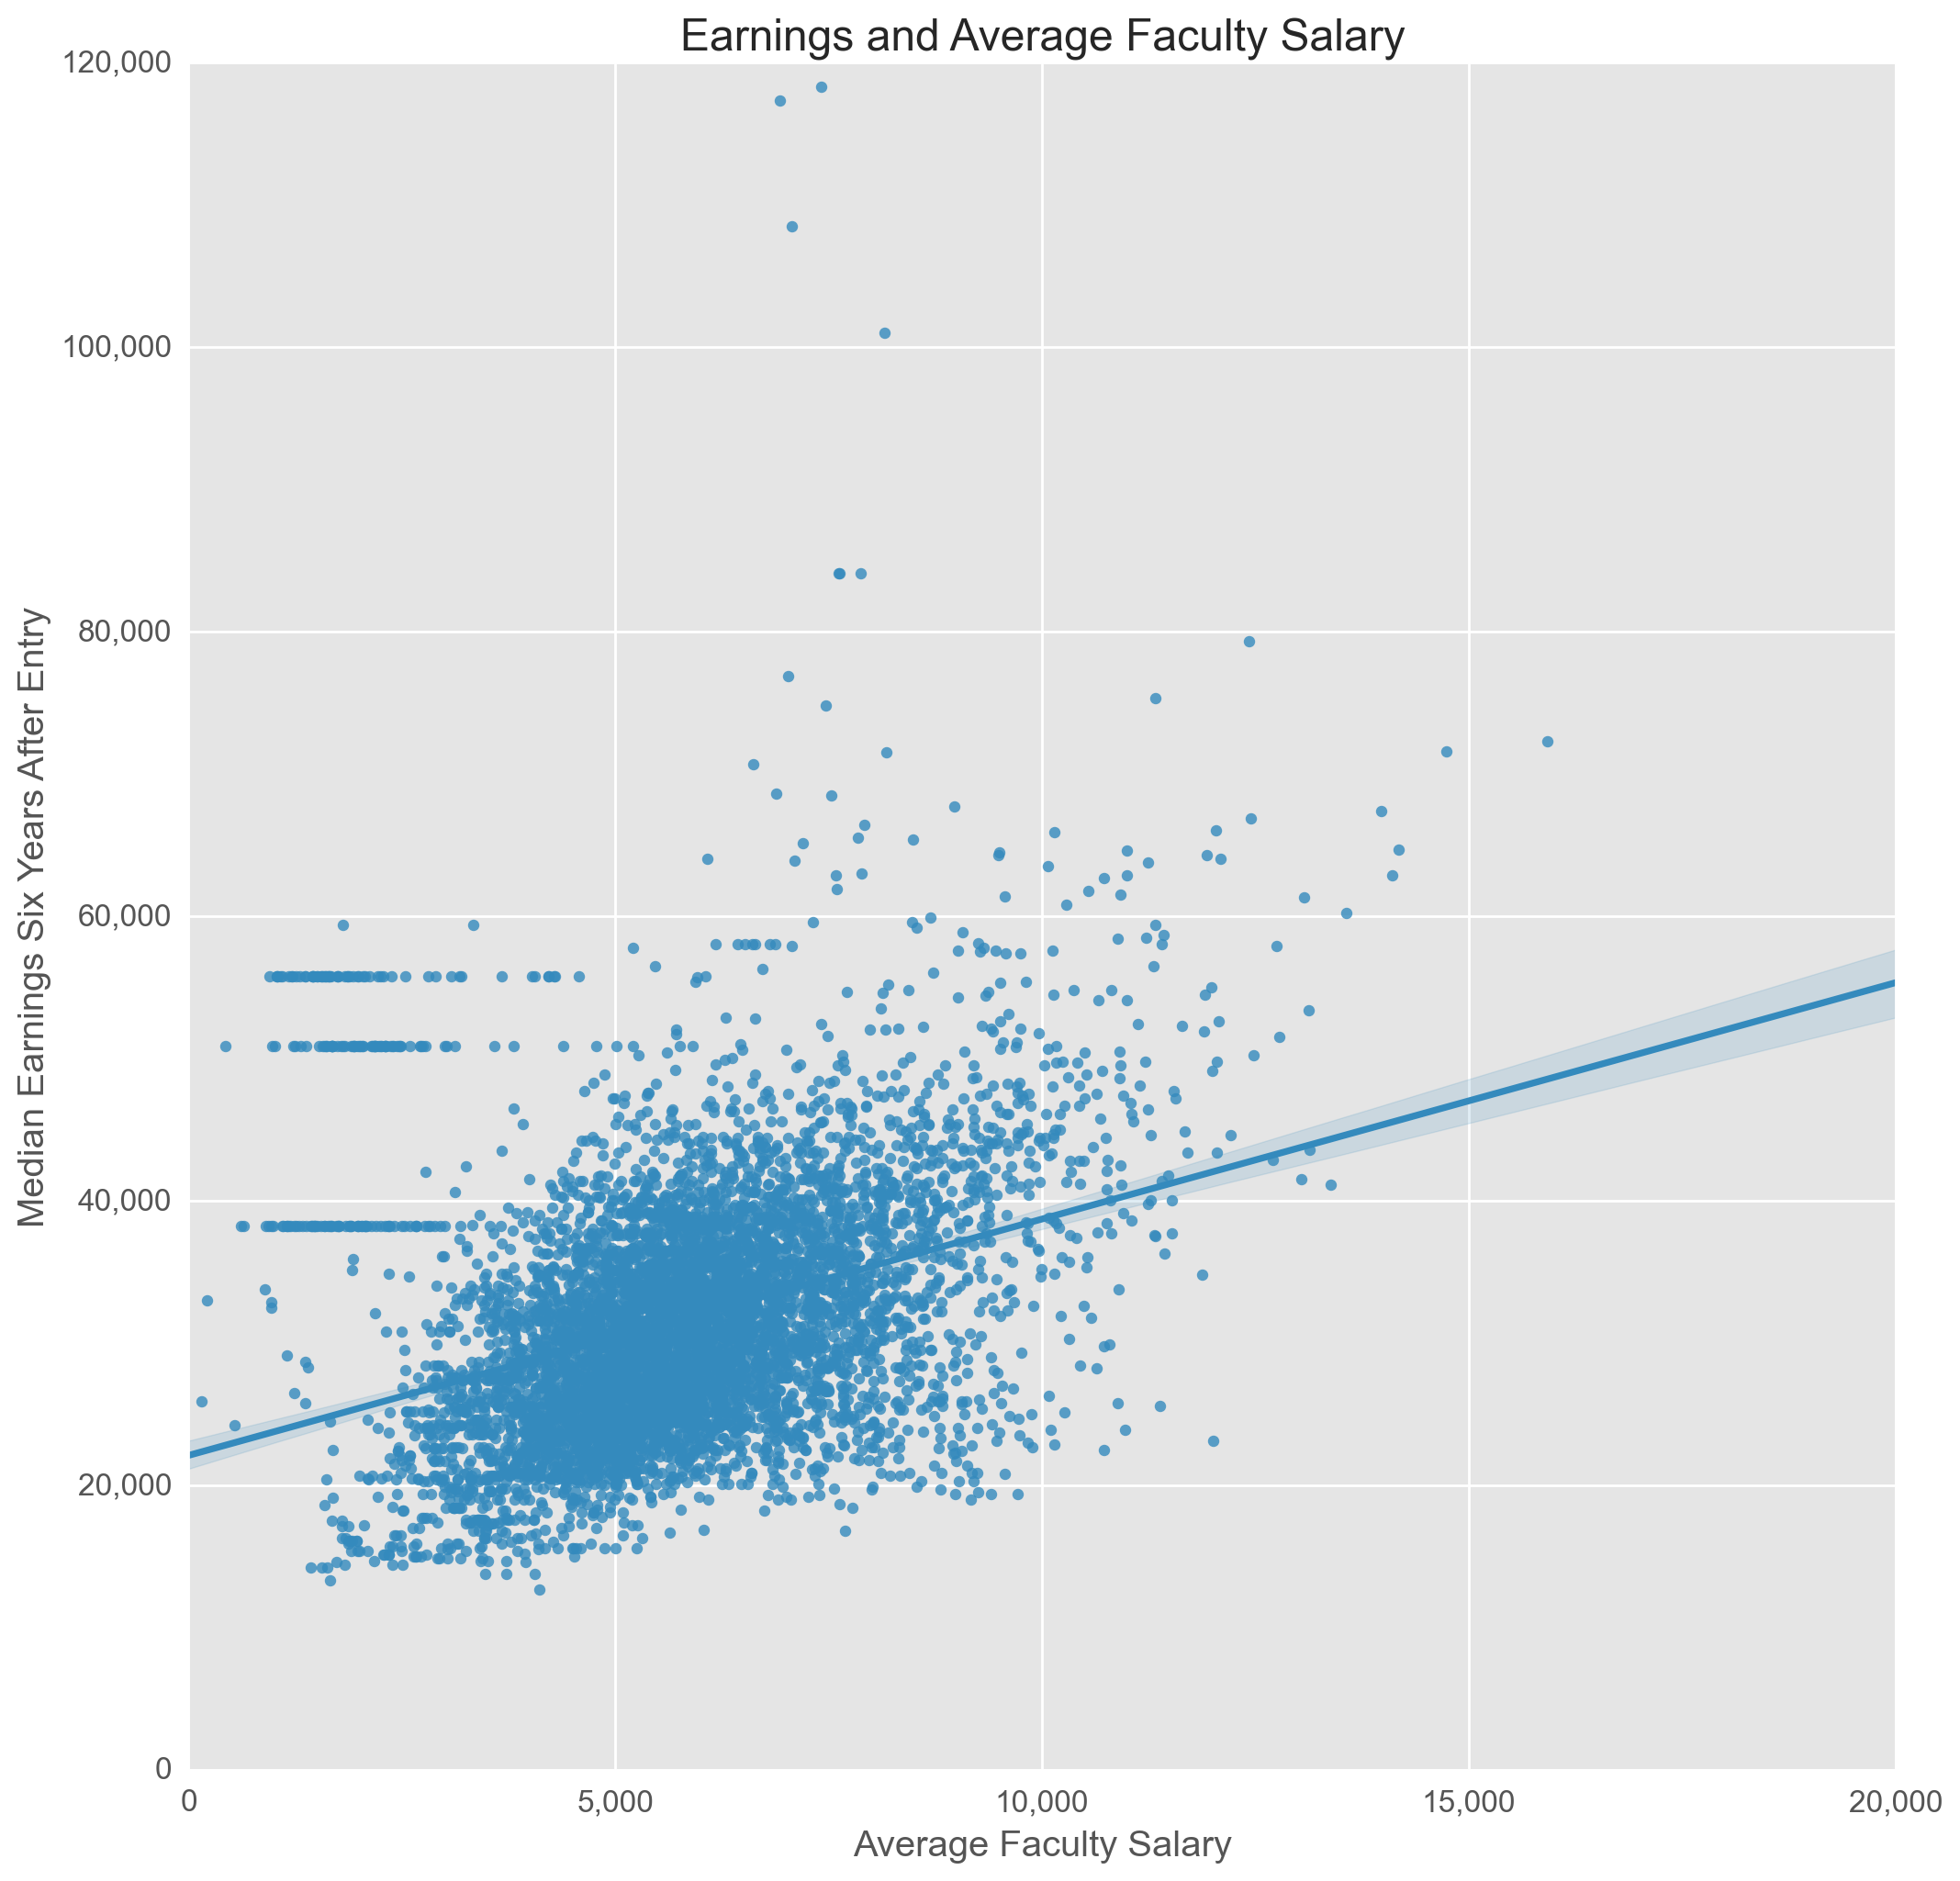

In [14]:
plt.figure(figsize=(12, 12))

sns.regplot(x=data_reduced.AVGFACSAL, y=data_reduced.md_earn_wne_p6, color='#348ABD');

plt.title('Earnings and Average Faculty Salary')
plt.xlabel('Average Faculty Salary')
plt.ylabel('Median Earnings Six Years After Entry')

plt.xlim(0, 20000);
plt.ylim(0, 120000);

plt.gca().get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
plt.gca().get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda y, p: format(int(y), ','))
)

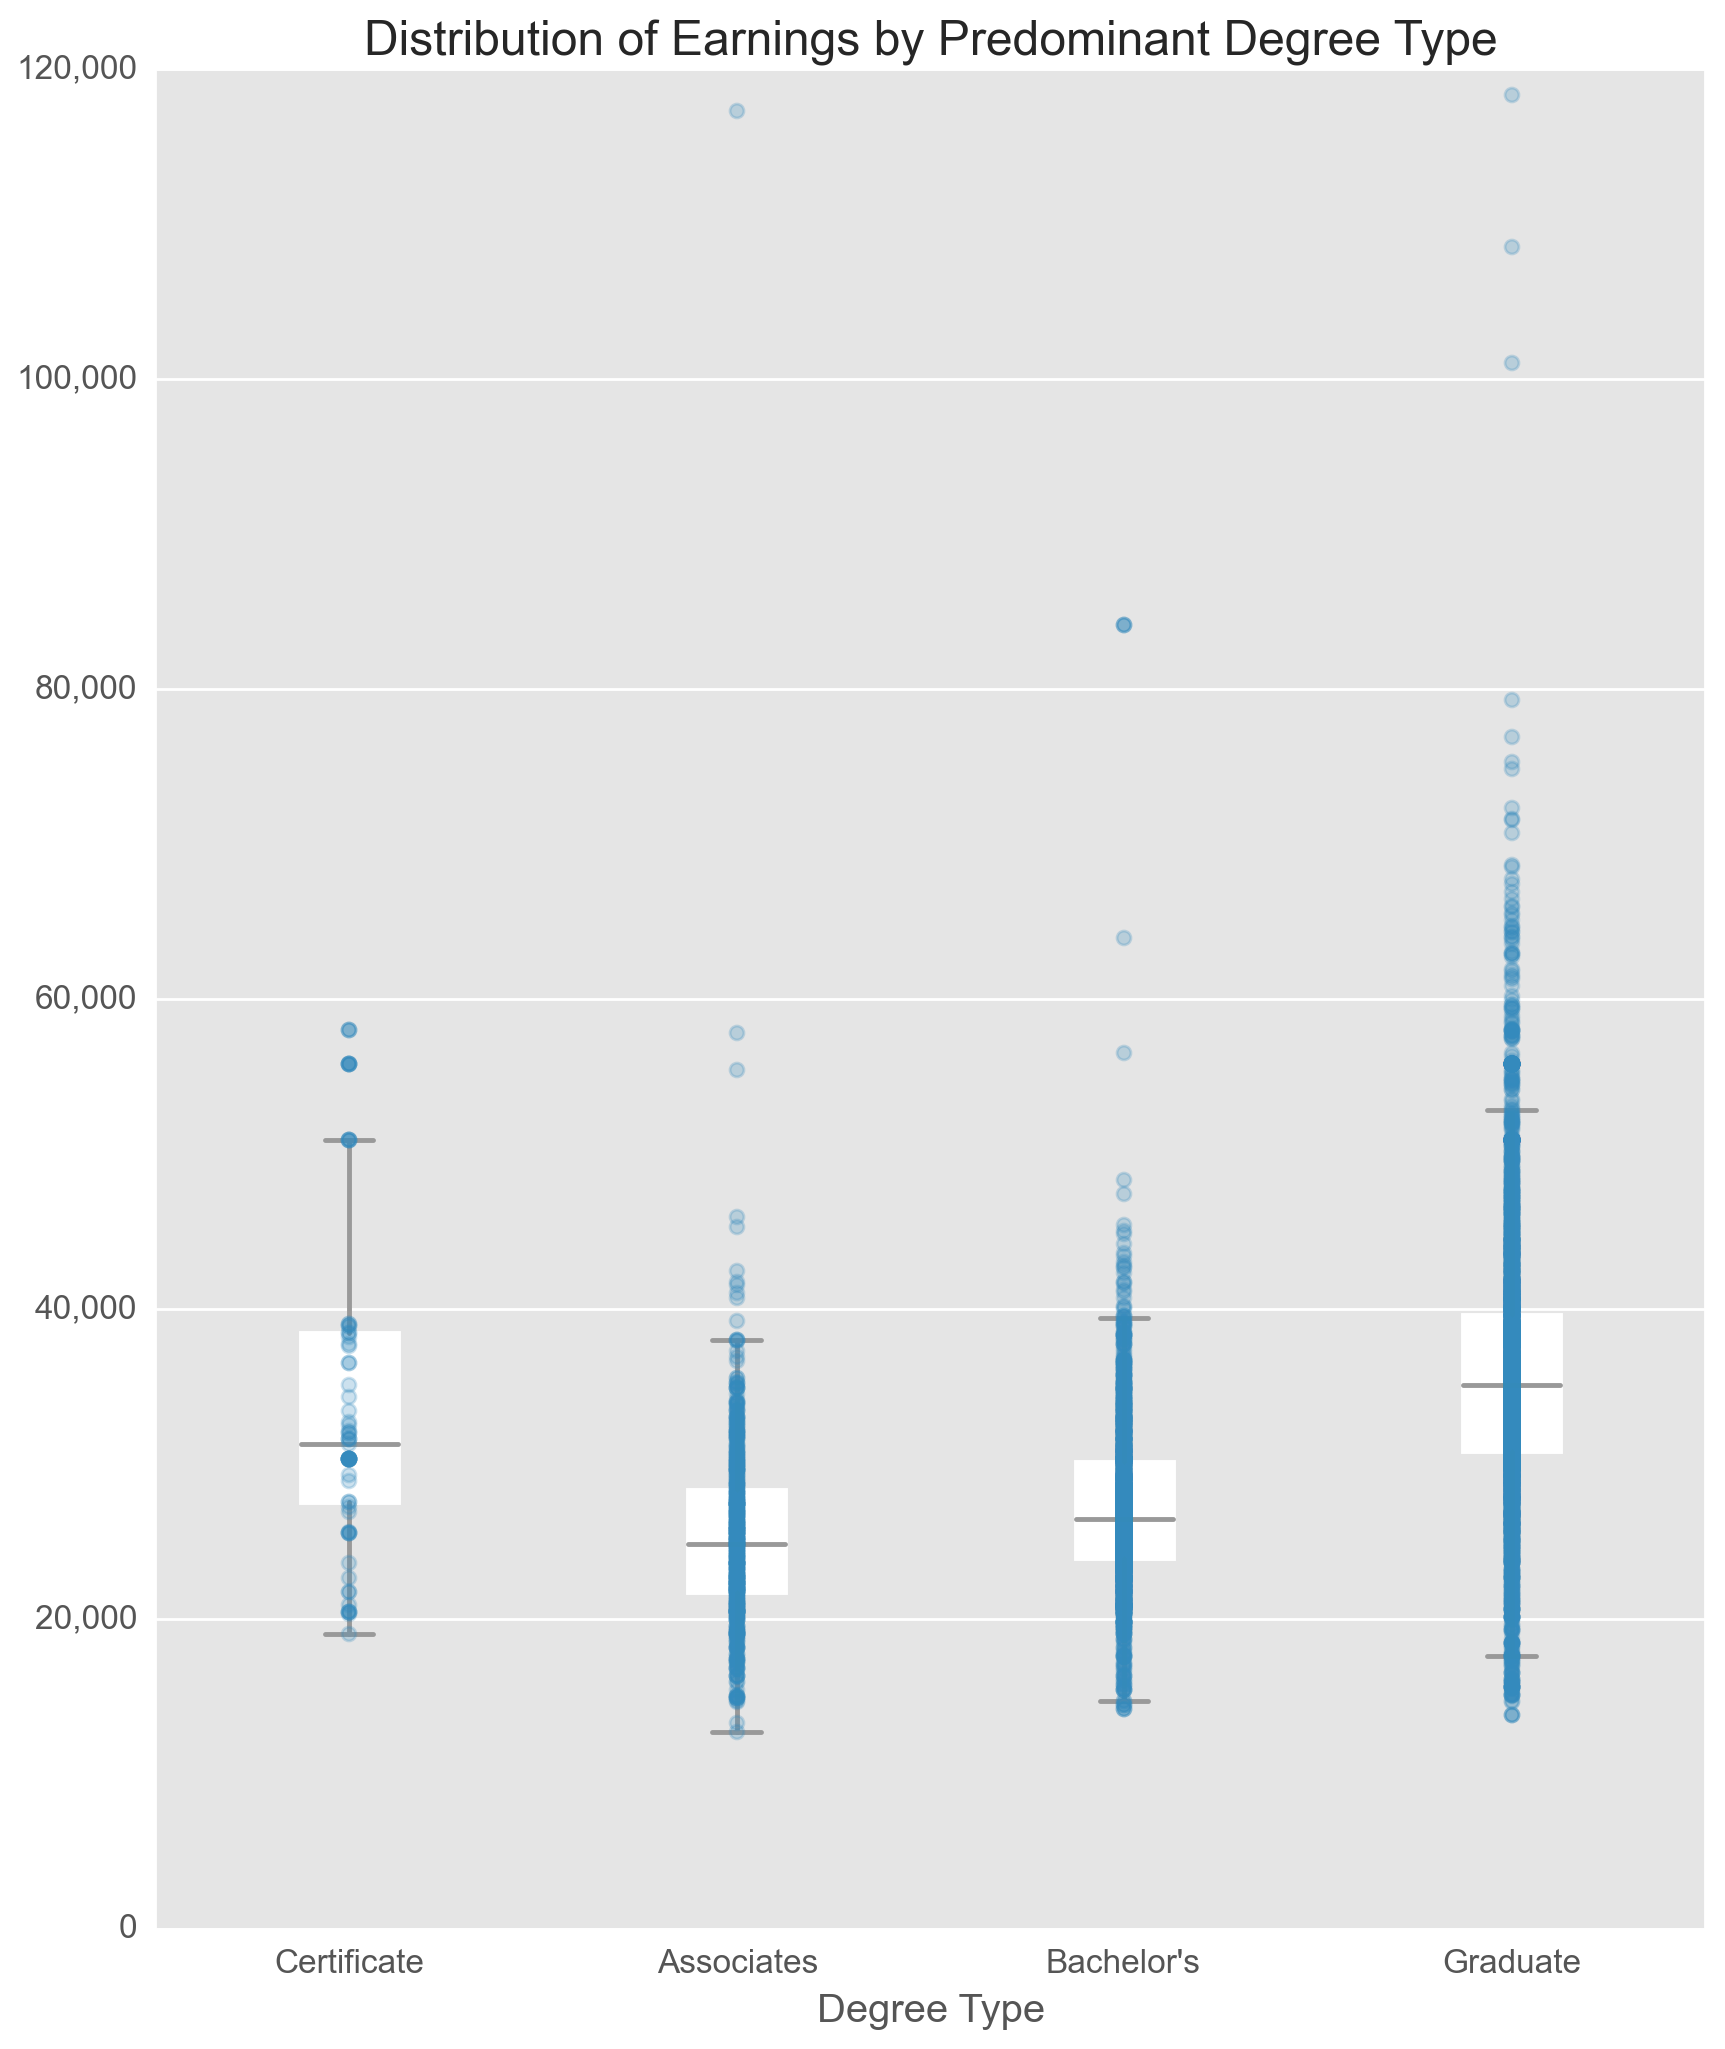

In [15]:
plt.figure(figsize=(10, 12))

sns.boxplot(x="PREDDEG", y="md_earn_wne_p6", data=data_reduced,
            order=np.sort(data_reduced.PREDDEG.unique()), color='White',
            fliersize=0, width=0.25)
sns.stripplot(x="PREDDEG", y="md_earn_wne_p6", data=data_reduced,
              order=np.sort(data_reduced.PREDDEG.unique()),
              alpha=0.25, size=5,
              color='#348ABD', edgecolor='#348ABD')

plt.title('Distribution of Earnings by Predominant Degree Type')
plt.xlabel('Degree Type')
plt.ylabel('')

plt.xticks(range(4), ['Certificate', 'Associates', 'Bachelor\'s', 'Graduate'])

plt.ylim(0, 120000);

plt.gca().get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda y, p: format(int(y), ','))
)